In [18]:
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

## Данные

собираю примеры из нескольких отдельных файлов

In [73]:
contrast_df = pd.read_csv('Data\contrast_clean_extended.tsv', sep='\t')
cause_df = pd.read_csv('Data\cause_clean_extended.tsv', sep='\t')

In [74]:
df1 = contrast_df
df1['relation'] = 'contrast'
df1.head()

,id,текст,relation
0,407,"В солнечный день, наверное, и вода играет друг...",contrast
1,921,там никто не в курсе никаких автобусов_говорят...,contrast
2,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast
3,1067,"Что ни говори, общий относительно приличный ур...",contrast
4,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast


In [75]:
df2 = cause_df
df2['relation'] = 'cause'
df2.head()

,id,текст,relation
0,24,"Помада довольно стойкая,_отлично переживет пер...",cause
1,101,Выпадает небольшой осадок._Всегда встряхиваю п...,cause
2,136,"зато есть ощущение, что присутствует муцин ули...",cause
3,206,"Не самый послушный,_может осыпаться под глаза.",cause
4,392,После октябрьской революции_монастырь официаль...,cause


склеиваю два датафрейма и проверяю, что нигде ничего не потерялось (нет пустых значений)

In [76]:
all_data = pd.concat([df1, df2], ignore_index=True)
all_data.isna().any()

id          False
текст       False
relation    False
dtype: bool

In [77]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
id          200 non-null int64
текст       200 non-null object
relation    200 non-null object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


Разделяю пример на две ЭДЕ по `_`

In [78]:
new_df = all_data['текст'].str.split('_',expand=True)
new_df = new_df.rename(columns={0:'эде1', 1:'эде2'})
all_data = pd.concat([ all_data, new_df[['эде1', 'эде2']] ], axis=1)
all_data.head()

,id,текст,relation,эде1,эде2
0,407,"В солнечный день, наверное, и вода играет друг...",contrast,"В солнечный день, наверное, и вода играет друг...","Главное, что это не повод сидеть дома,"
1,921,там никто не в курсе никаких автобусов_говорят...,contrast,там никто не в курсе никаких автобусов,говорят; что всё на автостанцию приходит.
2,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast,В каком-то проёме за щёлкой эти монетки и оста...,И даже никаких чеков автомат не выдаёт.
3,1067,"Что ни говори, общий относительно приличный ур...",contrast,"Что ни говори, общий относительно приличный ур...",Автобусный транспорт реально много где на уров...
4,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast,"Коробка красивая,","прибор явно туфтовый, даже по внешнему виду."


In [79]:
all_data.iloc[96:104]

,id,текст,relation,эде1,эде2
96,24927,"некоторые называют главным врагом Иран,_другие...",contrast,"некоторые называют главным врагом Иран,",другие указывают на Израиль или совсем иные ст...
97,25922,удары дронов приносят определенный краткосрочн...,contrast,удары дронов приносят определенный краткосрочн...,чего нельзя сказать о последствиях для долгоср...
98,29470,Этот статистический показатель адекватно харак...,contrast,Этот статистический показатель адекватно харак...,В случае сильной асимметрии рассуждения в терм...
99,30522,Для случая прозрачности жидкости и дна ротора ...,contrast,Для случая прозрачности жидкости и дна ротора ...,в противном случае - зеркалом.
100,24,"Помада довольно стойкая,_отлично переживет пер...",cause,"Помада довольно стойкая,",отлично переживет перекус.
101,101,Выпадает небольшой осадок._Всегда встряхиваю п...,cause,Выпадает небольшой осадок.,Всегда встряхиваю перед применением.
102,136,"зато есть ощущение, что присутствует муцин ули...",cause,"зато есть ощущение, что присутствует муцин ули...",консистенция крема какая-то тягучая.
103,206,"Не самый послушный,_может осыпаться под глаза.",cause,"Не самый послушный,",может осыпаться под глаза.


# Признаки

считаю все признаки, которые можно получить автоматически

## Длины

Токенизирую тексты и считаю следующие параметры (учитывая только слова, без пунктуации):

`n_words` - кол-во слов в каждой ЭДЕ

`av_words_length` - средняя длина слова в каждой ЭДЕ

`n_words_diff` - разница в кол-вах между словами (знак показывает, какая из ЭДЕ длинее)

In [80]:
import re
from razdel import tokenize

In [81]:
def tokenizer(text_data):
    tokens = [_.text for _ in list(tokenize(str(text_data).lower()))] #if not re.search('[^а-яА-ЯёЁa-zA-z]', _.text)]
    return " ".join(tokens)

def get_words(tokens):
    words = [token for token in tokens.split() if not re.search('[^а-яА-ЯёЁa-zA-z]', token)]
    return " ".join(words)

def count_words(words):
    return len(words.split())

def av_word_length(words):
    l = [len(word) for word in words.split()]
    return sum(l)/len(l)

In [82]:
for i in ['1', '2']:
    all_data['tokens'+i] = all_data['эде'+i].progress_apply(tokenizer)
    all_data['words'+i] = all_data['tokens'+i].progress_apply(get_words)
    all_data['n_words'+i] = all_data['words'+i].progress_apply(count_words)
    all_data['av_words_length'+i] = all_data['words'+i].progress_apply(av_word_length)

In [83]:
all_data['n_words_diff'] = all_data['n_words1'] - all_data['n_words2']

## Пунктуация между ЭДЕ

`punct` - знак препинания между двумя ЭДЕ (беру последний токен первой ЭДЕ). _None_ если знаков там нет. Данные заранее нормализованы вручную так, чтобы знак оставался в первом эелементе. 

In [84]:
def find_punct(tokens):
    last = tokens[-1]
    if last not in ['.', ',', ':', '-', '?', ')', '…']:
        last = 'none'
        
    return last

all_data['punct'] = all_data['tokens1'].apply(find_punct)
all_data['if punct'] = (all_data['punct'] != 'none')

## POS анализ

Считаю вектор со значениями всех частей речи и разбиваю его на отдельные признаки

In [85]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [86]:
tag_list = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN',
            'NPRO', 'NUMR', 'None', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']

In [87]:
def count_POS(words):
    POS_dict = {'ADJF': 0,
                'ADJS': 0,
                'ADVB': 0,
                'COMP': 0,
                'CONJ': 0,
                'GRND': 0,
                'INFN': 0,
                'INTJ': 0,
                'NOUN': 0,
                'NPRO': 0,
                'NUMR': 0,
                'None': 0,
                'PRCL': 0,
                'PRED': 0,
                'PREP': 0,
                'PRTF': 0,
                'PRTS': 0,
                'VERB': 0}
    
    for word in words.split():
        p = morph.parse(word)[0]
        tag = p.tag.POS
        if tag is None:
            tag = 'None'
        POS_dict[tag] += 1
    return list(POS_dict.values())

In [88]:
for i in ['1', '2']:
    all_data['pos_vector'+i] = all_data['words'+i].progress_apply(count_POS)
    
    all_data[ [tag+i for tag in tag_list] ] = pd.DataFrame(all_data['pos_vector'+i].tolist())

## Повторяющиеся слова

Лемматизирую тексты и считаю сколько слов встречаются в обеих ЭДЕ

In [89]:
def lemmatizer(words):
    lem_text = []
    for word in words.split():
        lem = morph.parse(word)[0].normal_form
#         if lem not in stops:
        lem_text.append(lem)
    return ' '.join(lem_text)

def similar_words(lemm_a, lemm_b):
    return list(set(lemm_a.split()) & set(lemm_b.split()))

In [90]:
for i in ['1', '2']:
    all_data['lemm'+i] = all_data['words'+i].progress_apply(lemmatizer)

In [91]:
all_data['similar_words'] = all_data.apply(lambda x: similar_words(x['lemm1'], x['lemm2']), axis=1)
all_data['n_similar_words'] = all_data['similar_words'].apply(len)

In [92]:
all_data[all_data['n_similar_words'] != 0]['similar_words']

2                                          [и]
3                         [уровень, транспорт]
9                                          [с]
11                                    [бывать]
15                                       [кот]
18                                    [писать]
20                                       [для]
21                                  [хотеться]
22          [результат, быстрый, путь, к, это]
23                         [быть, пищеварение]
25                           [тестер, платить]
26                                  [работать]
27                         [ресурс, требовать]
28                                    [способ]
30                                       [что]
32                                [технология]
34                                        [не]
35                                 [хотеть, я]
37                     [сказать, мочь, я, что]
39                                  [удобство]
41                   [значит, это, что, нужно]
42           

## Эмбединги

Обучаю модель, получаю вектора размерности 10 для каждой пары ЭДЕ и считаю их косинусную близовть. Вектора разбиваю на 10 отдельных признаков. Как дальше покажут эксперименты, если использовать эти 10 отдельных признаков, то почти все модели получаются сильно завязаны на каку-то их часть, при этом если их не использовать - качество не особо и меняется. Так что в итоге при обучении я буду использовать только значение близости между векторами двух ЭДЕ `cosine_d2v`.

### doc2vec

In [93]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [94]:
corpora = all_data['lemm1'].values.tolist() + all_data['lemm2'].values.tolist()
len(corpora)

400

In [95]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(corpora)]
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1)

In [96]:
def get_d2v_vector(lemm):
    return model.infer_vector(lemm.split())

def cosine_d2v(lemm1, lemm2):
    return model.wv.n_similarity(lemm1.split(),lemm2.split())

In [97]:
for i in ['1', '2']:
    all_data['d2v_vector'+i] = all_data['lemm'+i].progress_apply(get_d2v_vector)
    all_data[ ['v'+str(n)+'_'+i for n in range(10)] ] = pd.DataFrame(all_data['d2v_vector'+i].tolist())

In [98]:
all_data['cosine_d2v'] = all_data.apply(lambda x: cosine_d2v(x['lemm1'], x['lemm2']), axis=1)

### Сохранение всех результатов экселе

In [99]:
all_data.to_excel('Data\data_full_markup.xlsx')

# Модели

In [100]:
import numpy as np
from sklearn.metrics import classification_report

## Обчающая и тестовая выборки

In [101]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [124]:
not_features = ['id', 'текст',
                'эде1', 'эде2',
                'tokens1', 'tokens2',
                'words1', 'words2',
                'pos_vector1', 'pos_vector2',
                'lemm1', 'lemm2',
                'similar_words', 'if punct', 
                'd2v_vector1', 'd2v_vector2']

not_features.extend(['v'+str(n)+'_'+'1' for n in range(10)])
not_features.extend(['v'+str(n)+'_'+'2' for n in range(10)])

features = list(set(all_data.columns.values.tolist()) - set(not_features))

data = all_data.drop(columns=not_features)
data = data.apply(LabelEncoder().fit_transform) # 1 = contrast, 0 = cause

X = data.drop(columns=['relation'])
y = data['relation']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [125]:
len(features)

45

In [128]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 154 to 5
Data columns (total 44 columns):
n_words1            160 non-null int64
av_words_length1    160 non-null int64
n_words2            160 non-null int64
av_words_length2    160 non-null int64
n_words_diff        160 non-null int64
punct               160 non-null int32
ADJF1               160 non-null int64
ADJS1               160 non-null int64
ADVB1               160 non-null int64
COMP1               160 non-null int64
CONJ1               160 non-null int64
GRND1               160 non-null int64
INFN1               160 non-null int64
INTJ1               160 non-null int64
NOUN1               160 non-null int64
NPRO1               160 non-null int64
NUMR1               160 non-null int64
None1               160 non-null int64
PRCL1               160 non-null int64
PRED1               160 non-null int64
PREP1               160 non-null int64
PRTF1               160 non-null int64
PRTS1               160 non-null int6

## Логистическая регрессия

In [129]:
from sklearn.linear_model import LogisticRegression

In [130]:
lreg = LogisticRegression(random_state=42)
lreg.fit(X_train, y_train)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [131]:
y_pred_lreg = lreg.predict(X_test)
print(classification_report(y_test, y_pred_lreg))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.77      0.50      0.61        20

    accuracy                           0.68        40
   macro avg       0.70      0.68      0.66        40
weighted avg       0.70      0.68      0.66        40



In [132]:
feature_importances_lreg = lreg.coef_
for ind in np.argsort(-feature_importances_lreg[0]):
    print(X_train.columns[ind], '-', feature_importances_lreg[0][ind])

ADJS1 - 1.085441197099366
INTJ1 - 1.0293079088221717
n_similar_words - 0.7371931103399947
PRCL2 - 0.6429721059209502
VERB1 - 0.5880565013937814
ADJF2 - 0.5622177777973437
NPRO2 - 0.45557345138561595
None2 - 0.45522497737707995
INTJ2 - 0.45412598029400736
PREP2 - 0.4172867754400803
PRED1 - 0.4031741799485455
NUMR1 - 0.24942471483632453
CONJ2 - 0.24552549208040486
ADJF1 - 0.22714057703189525
ADJS2 - 0.21028239873406304
PRCL1 - 0.2071600151088745
INFN1 - 0.18354885744804522
n_words1 - 0.1737286548720663
ADVB1 - 0.13371611677645603
punct - 0.12203823284452073
PRTS1 - 0.10400063363620218
NOUN1 - 0.0918560400569942
COMP2 - 0.058632208244127126
NOUN2 - 0.013461147644860429
av_words_length2 - 0.008952918558857595
av_words_length1 - 0.0037074565335378827
cosine_d2v - 0.003665545642884344
PRED2 - -0.056327592768354466
PREP1 - -0.10130332563913814
CONJ1 - -0.12613840903469667
n_words_diff - -0.16081292295999156
ADVB2 - -0.19538871966479607
PRTF2 - -0.21614062955027466
GRND1 - -0.2216962412363006


## Decision Tree

In [133]:
from sklearn.tree import DecisionTreeClassifier

In [134]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [135]:
y_pred_tree = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63        20
           1       0.58      0.35      0.44        20

    accuracy                           0.55        40
   macro avg       0.56      0.55      0.53        40
weighted avg       0.56      0.55      0.53        40



In [136]:
feature_importances_tree = tree_clf.feature_importances_
for ind in np.argsort(-feature_importances_tree):
    print(X_train.columns[ind], '-', feature_importances_tree[ind])

n_similar_words - 0.10121457489878546
n_words2 - 0.09503331438676267
cosine_d2v - 0.09396617621407535
av_words_length2 - 0.07282388663967611
NPRO1 - 0.07190521227406474
av_words_length1 - 0.06168425872373238
n_words_diff - 0.0604370596302076
n_words1 - 0.04534035982814179
GRND1 - 0.04292679479932162
PRCL2 - 0.03215348639455786
ADJS1 - 0.03109507954125048
INFN1 - 0.03
GRND2 - 0.029701468710089385
CONJ2 - 0.029166666666666667
ADJF1 - 0.028356950067476395
ADJF2 - 0.02739049145299146
COMP2 - 0.02291666666666667
COMP1 - 0.021428571428571432
ADVB1 - 0.0188673469387755
PREP1 - 0.01875
PRTF1 - 0.018409586056644896
INFN2 - 0.018127450980392146
PRTF2 - 0.016666666666666666
PREP2 - 0.01163793103448274
punct - 0.0
VERB2 - 0.0
PRTS2 - 0.0
PRED2 - 0.0
CONJ1 - 0.0
None2 - 0.0
NUMR2 - 0.0
NPRO2 - 0.0
NOUN2 - 0.0
INTJ2 - 0.0
INTJ1 - 0.0
NOUN1 - 0.0
NUMR1 - 0.0
ADVB2 - 0.0
None1 - 0.0
PRCL1 - 0.0
VERB1 - 0.0
PRTS1 - 0.0
PRED1 - 0.0
ADJS2 - 0.0


## Random Forest

In [137]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [143]:
y_pred_forest = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.64      0.45      0.53        20

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.59        40
weighted avg       0.61      0.60      0.59        40



In [144]:
feature_importances_forest = rf_clf.feature_importances_
for ind in np.argsort(-feature_importances_forest):
    print(X_train.columns[ind], '-', feature_importances_forest[ind])

cosine_d2v - 0.08465074242743144
av_words_length2 - 0.07007484208913177
av_words_length1 - 0.06744173692821456
n_similar_words - 0.06330606597959737
n_words1 - 0.061439707825010015
n_words_diff - 0.06007311341534713
n_words2 - 0.05017453222401222
NOUN1 - 0.04574398338461655
NOUN2 - 0.03569061725639318
ADJF2 - 0.032003661600512136
punct - 0.0305962896322699
PRCL2 - 0.02710915138925103
PRCL1 - 0.026821068154556094
ADJF1 - 0.026147839028649065
ADVB1 - 0.022337789146219644
PREP2 - 0.021402243269407206
CONJ1 - 0.019730318375483
VERB2 - 0.019711038032686253
PREP1 - 0.01947171908269157
VERB1 - 0.019341113747626985
ADVB2 - 0.01819764794094001
GRND2 - 0.016368330440283897
NPRO1 - 0.015891536472549487
INFN2 - 0.014941306270728585
INFN1 - 0.014356348540528847
CONJ2 - 0.013900377117687587
PRTF1 - 0.012735254473343373
GRND1 - 0.011953334069210968
NPRO2 - 0.011263226106096607
ADJS1 - 0.011031806543122491
INTJ1 - 0.007713557088207694
COMP2 - 0.007688536834348228
COMP1 - 0.0051540212028077645
PRED1 - 

## SVM

In [145]:
from sklearn.svm import SVC

In [146]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [147]:
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.76      0.65      0.70        20

    accuracy                           0.73        40
   macro avg       0.73      0.73      0.72        40
weighted avg       0.73      0.72      0.72        40



In [148]:
feature_importances_svc = svc.coef_
for ind in np.argsort(-feature_importances_svc[0]):
    print(X_train.columns[ind], '-', feature_importances_svc[0][ind])

INTJ1 - 1.0537772868181863
PRCL2 - 0.8366666515072936
ADJS1 - 0.8024009109772537
n_similar_words - 0.6536490444927135
None2 - 0.6267285835610545
VERB1 - 0.5649043686559256
PRED1 - 0.5560871430748581
n_words1 - 0.5533508587846967
NPRO2 - 0.5494544425525598
PRTS1 - 0.5198813217358829
PREP2 - 0.4324686668335658
CONJ2 - 0.34978281941562583
INFN1 - 0.330652903554026
ADJF2 - 0.30701568047839345
COMP2 - 0.22297934246193402
ADJF1 - 0.2093584154360233
INTJ2 - 0.17958140669064565
NUMR1 - 0.1672405951813677
PRCL1 - 0.09536154326484958
PREP1 - 0.07514152214946712
punct - 0.06394758165490533
NOUN1 - 0.0638107194450015
ADJS2 - 0.0548502136181268
av_words_length2 - 0.018238563727772217
av_words_length1 - 0.005080945181463292
cosine_d2v - 0.004100595454538336
NUMR2 - 0.0
PRTS2 - 0.0
GRND1 - 0.0
ADVB1 - -0.02362721467973783
NOUN2 - -0.11433054404462162
ADVB2 - -0.18780568379315188
CONJ1 - -0.21548620696225962
INFN2 - -0.2600499508677143
NPRO1 - -0.28573079612080443
VERB2 - -0.315127265500486
PRTF2 - -0

## Сравнение качества моделей

### F1-score

In [149]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['f1-score']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['f1-score']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['f1-score']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['f1-score']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.723404,0.6250,0.652174,0.744186
contrast,0.606061,0.4375,0.529412,0.702703


### Precision

In [150]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['precision']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['precision']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['precision']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['precision']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.629630,0.535714,0.576923,0.695652
contrast,0.769231,0.583333,0.642857,0.764706


### Recall

In [151]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['recall']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['recall']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['recall']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['recall']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.85,0.75,0.75,0.80
contrast,0.50,0.35,0.45,0.65


## Сравнение важности признаков

Сравниваю абсолютные значения всех признаков

In [152]:
features = pd.DataFrame({'LReg': abs(feature_importances_lreg[0]), 
              'DTree': feature_importances_tree, 
              'RForest': feature_importances_forest,
              'SVM': abs(feature_importances_svc[0]),}, index=X_train.columns)

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

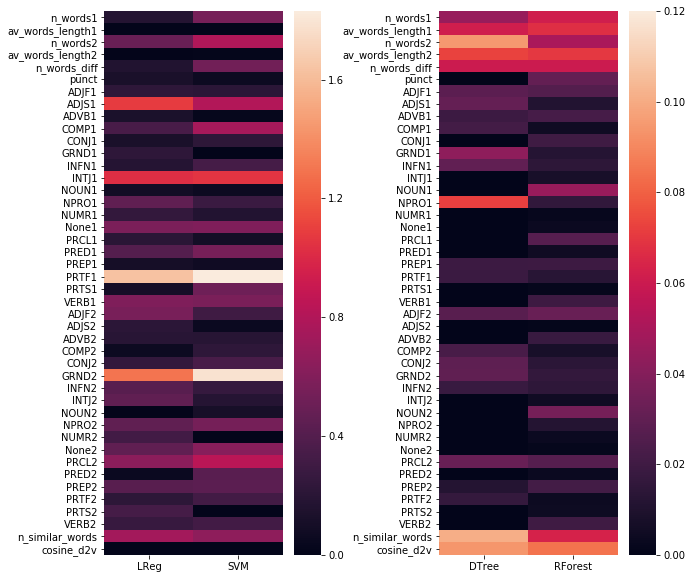

In [154]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(10,10))
fig.subplots_adjust(wspace=0.5)
sns.heatmap(features[['LReg', 'SVM']], cmap="rocket", ax=ax, cbar=True, vmin=0)
sns.heatmap(features[['DTree', 'RForest']], cmap="rocket", ax=ax2, cbar=True, vmax=0.12)
plt.show()

In [155]:
features

,LReg,DTree,RForest,SVM
n_words1,0.173729,0.045340,0.061440,0.553351
av_words_length1,0.003707,0.061684,0.067442,0.005081
n_words2,0.491225,0.095033,0.050175,0.795626
av_words_length2,0.008953,0.072824,0.070075,0.018239
n_words_diff,0.160813,0.060437,0.060073,0.529260
punct,0.122038,0.000000,0.030596,0.063948
ADJF1,0.227141,0.028357,0.026148,0.209358
ADJS1,1.085441,0.031095,0.011032,0.802401
ADVB1,0.133716,0.018867,0.022338,0.023627
COMP1,0.345917,0.021429,0.005154,0.754062


_Анна Полянская, НИУ ВШЭ, 2020_